# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
import os
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'
import warnings
warnings.filterwarnings('ignore')

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
# Define a function to load data and aggregate them

def load_combine_data(list_of_files):
    individual_stock_frames = []  # List to hold each stock's DataFrame

    for file in list_of_files:
        # Extract stock ticker from file name (e.g., 'AMZN_stock_data.csv' -> 'AMZN')
        stock_ticker = os.path.basename(file).split('_')[0]

        # Read the CSV file
        stock_df = pd.read_csv(file)

        # Drop unnecessary columns
        stock_df = stock_df.drop(columns=['Name'])

        # Rename columns to include the stock ticker prefix, except for 'Date'
        stock_df.columns = ['Date'] + [f'{stock_ticker}_{col}' for col in stock_df.columns[1:]]

        # Convert 'Date' to datetime
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])

        # Add the processed DataFrame to the list
        individual_stock_frames.append(stock_df)

    # Merge all stock DataFrames on 'Date'
    combined_dataframe = individual_stock_frames[0]
    for stock_frame in individual_stock_frames[1:]:
        combined_dataframe = pd.merge(combined_dataframe, stock_frame, on='Date', how='outer')

    # Set 'Date' as the index
    combined_dataframe.set_index('Date', inplace=True)

    return combined_dataframe

In [3]:
#Mounting google drive for loading data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

file1 = '/content/drive/MyDrive/ML_RNN_PROJECT/AMZN_stocks_data.csv'
file2 = '/content/drive/MyDrive/ML_RNN_PROJECT/GOOGL_stocks_data.csv'
file3 = '/content/drive/MyDrive/ML_RNN_PROJECT/IBM_stocks_data.csv'
file4 = '/content/drive/MyDrive/ML_RNN_PROJECT/MSFT_stocks_data.csv'

list_of_files = [file1, file2,file3,file4]
combined_stock_df = load_combine_data(list_of_files)


In [5]:
# View specifics of the data

combined_stock_df.head()

,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume
Date,,,,,,,,,,,,,,,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127.0,211.47,218.05,209.32,217.83,13137450.0,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418.0
2006-01-04,47.48,47.73,46.69,47.25,7440914.0,222.17,224.70,220.09,222.84,15292353.0,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661.0
2006-01-05,47.16,48.20,47.11,47.65,5417258.0,223.22,226.00,220.97,225.85,10815661.0,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610.0
2006-01-06,47.97,48.58,47.32,47.87,6154285.0,228.66,235.49,226.85,233.06,17759521.0,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092.0
2006-01-09,46.55,47.10,46.40,47.08,8945056.0,233.44,236.94,230.70,233.68,12795837.0,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836.0


In [6]:
#Checking the info on data

combined_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AMZN_Open     3019 non-null   float64
 1   AMZN_High     3019 non-null   float64
 2   AMZN_Low      3019 non-null   float64
 3   AMZN_Close    3019 non-null   float64
 4   AMZN_Volume   3019 non-null   float64
 5   GOOGL_Open    3019 non-null   float64
 6   GOOGL_High    3019 non-null   float64
 7   GOOGL_Low     3019 non-null   float64
 8   GOOGL_Close   3019 non-null   float64
 9   GOOGL_Volume  3019 non-null   float64
 10  IBM_Open      3019 non-null   float64
 11  IBM_High      3020 non-null   float64
 12  IBM_Low       3019 non-null   float64
 13  IBM_Close     3020 non-null   float64
 14  IBM_Volume    3020 non-null   int64  
 15  MSFT_Open     3019 non-null   float64
 16  MSFT_High     3019 non-null   float64
 17  MSFT_Low      3019 non-null   float64
 18  MSFT_Close

In [7]:
#Describe the data
combined_stock_df.describe()

,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03,3019.000000,3020.000000,3019.000000,3020.000000,3.020000e+03,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,299.335310,302.371163,296.037695,299.376231,5.931712e+06,428.200802,431.835618,424.130275,428.044001,3.551504e+06,145.515545,146.681738,144.471597,145.617278,5.773301e+06,36.496817,36.827903,36.173190,36.513412,5.161762e+07
std,280.120547,281.826442,277.927134,279.980161,5.122034e+06,236.320026,237.514087,234.923747,236.343238,3.038599e+06,37.554946,37.613446,37.477641,37.529387,3.192831e+06,14.683337,14.742483,14.620057,14.694656,3.114958e+07
min,26.090000,26.300000,25.760000,26.070000,9.864350e+05,131.390000,134.820000,123.770000,128.850000,5.211410e+05,72.740000,73.940000,69.500000,71.740000,2.542560e+05,15.200000,15.620000,14.870000,15.150000,7.425603e+06
25%,81.175000,82.580000,79.725000,81.090000,3.137037e+06,247.775000,250.190000,244.035000,247.605000,1.760854e+06,116.405000,117.765000,115.490000,116.525000,3.622681e+06,26.785000,27.045000,26.535000,26.835000,3.136557e+07
50%,205.330000,208.000000,202.100000,205.440000,4.724100e+06,310.480000,312.810000,307.790000,310.080000,2.517630e+06,149.610000,150.330000,148.470000,149.315000,4.928852e+06,29.990000,30.230000,29.780000,30.000000,4.617529e+07
75%,375.570000,379.155000,373.000000,375.140000,7.135246e+06,572.140000,575.975000,565.900000,570.770000,4.242182e+06,178.445000,179.762500,177.330000,178.685000,6.965014e+06,44.545000,44.980000,44.090000,44.400000,6.322291e+07
max,1204.880000,1213.410000,1191.150000,1195.830000,1.044046e+08,1083.020000,1086.490000,1072.270000,1085.090000,4.118289e+07,215.380000,215.900000,214.300000,215.800000,3.077428e+07,87.120000,87.500000,86.230000,86.850000,5.910786e+08


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [8]:
def handle_missing_values(df):
    missing_values_before = df.isnull().sum()
    print("Missing values in each column:\n", missing_values_before)

    # Select only numerical columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(method='ffill')

    # Fill NaNs with column medians
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

    # Check and display missing values after filling
    missing_values_after = df.isnull().sum()
    print("\nMissing values after fixing:\n", missing_values_after)

    return df

In [9]:
# Handle Missing Values

combined_stock_df = handle_missing_values(combined_stock_df)


Missing values in each column:
 AMZN_Open       1
AMZN_High       1
AMZN_Low        1
AMZN_Close      1
AMZN_Volume     1
GOOGL_Open      1
GOOGL_High      1
GOOGL_Low       1
GOOGL_Close     1
GOOGL_Volume    1
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       1
MSFT_High       1
MSFT_Low        1
MSFT_Close      1
MSFT_Volume     1
dtype: int64

Missing values after fixing:
 AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        0
IBM_High        0
IBM_Low         0
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
dtype: int64


In [10]:
#Checking data after NaN fixing
combined_stock_df.head()

,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Volume,GOOGL_Open,GOOGL_High,GOOGL_Low,GOOGL_Close,GOOGL_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Volume
Date,,,,,,,,,,,,,,,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127.0,211.47,218.05,209.32,217.83,13137450.0,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418.0
2006-01-04,47.48,47.73,46.69,47.25,7440914.0,222.17,224.70,220.09,222.84,15292353.0,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661.0
2006-01-05,47.16,48.20,47.11,47.65,5417258.0,223.22,226.00,220.97,225.85,10815661.0,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610.0
2006-01-06,47.97,48.58,47.32,47.87,6154285.0,228.66,235.49,226.85,233.06,17759521.0,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092.0
2006-01-09,46.55,47.10,46.40,47.08,8945056.0,233.44,236.94,230.70,233.68,12795837.0,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836.0


In [11]:
#checking for any null values after removing null values
combined_stock_df.isnull().sum()

,0
AMZN_Open,0
AMZN_High,0
AMZN_Low,0
AMZN_Close,0
AMZN_Volume,0
GOOGL_Open,0
GOOGL_High,0
GOOGL_Low,0
GOOGL_Close,0
GOOGL_Volume,0


In [12]:
#Checking info after dropping
combined_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AMZN_Open     3020 non-null   float64
 1   AMZN_High     3020 non-null   float64
 2   AMZN_Low      3020 non-null   float64
 3   AMZN_Close    3020 non-null   float64
 4   AMZN_Volume   3020 non-null   float64
 5   GOOGL_Open    3020 non-null   float64
 6   GOOGL_High    3020 non-null   float64
 7   GOOGL_Low     3020 non-null   float64
 8   GOOGL_Close   3020 non-null   float64
 9   GOOGL_Volume  3020 non-null   float64
 10  IBM_Open      3020 non-null   float64
 11  IBM_High      3020 non-null   float64
 12  IBM_Low       3020 non-null   float64
 13  IBM_Close     3020 non-null   float64
 14  IBM_Volume    3020 non-null   int64  
 15  MSFT_Open     3020 non-null   float64
 16  MSFT_High     3020 non-null   float64
 17  MSFT_Low      3020 non-null   float64
 18  MSFT_Close

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

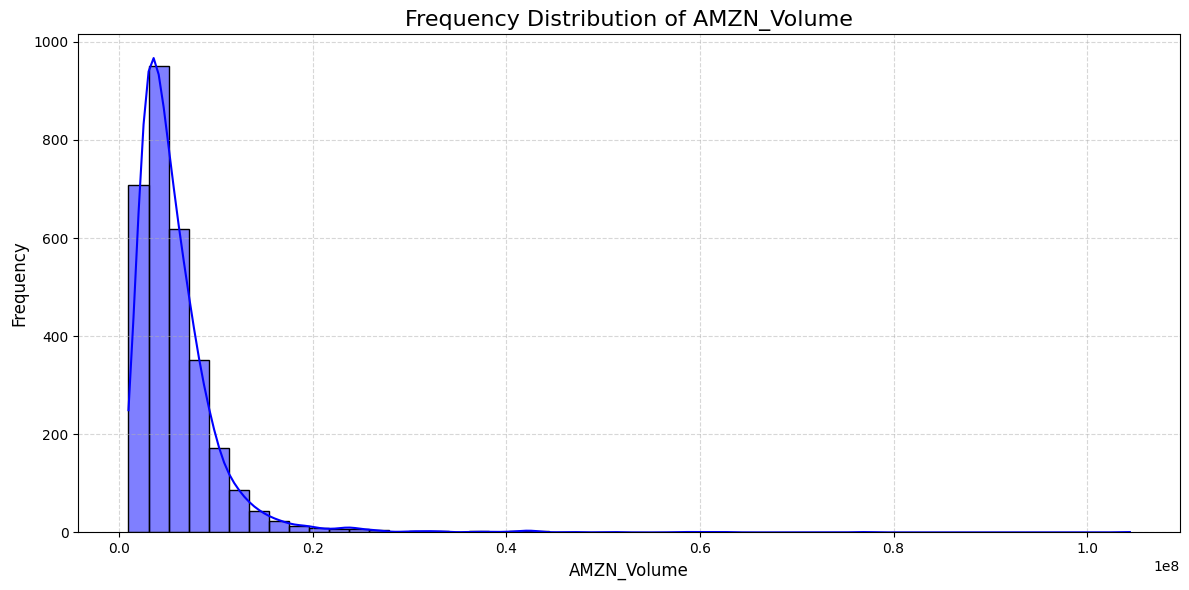

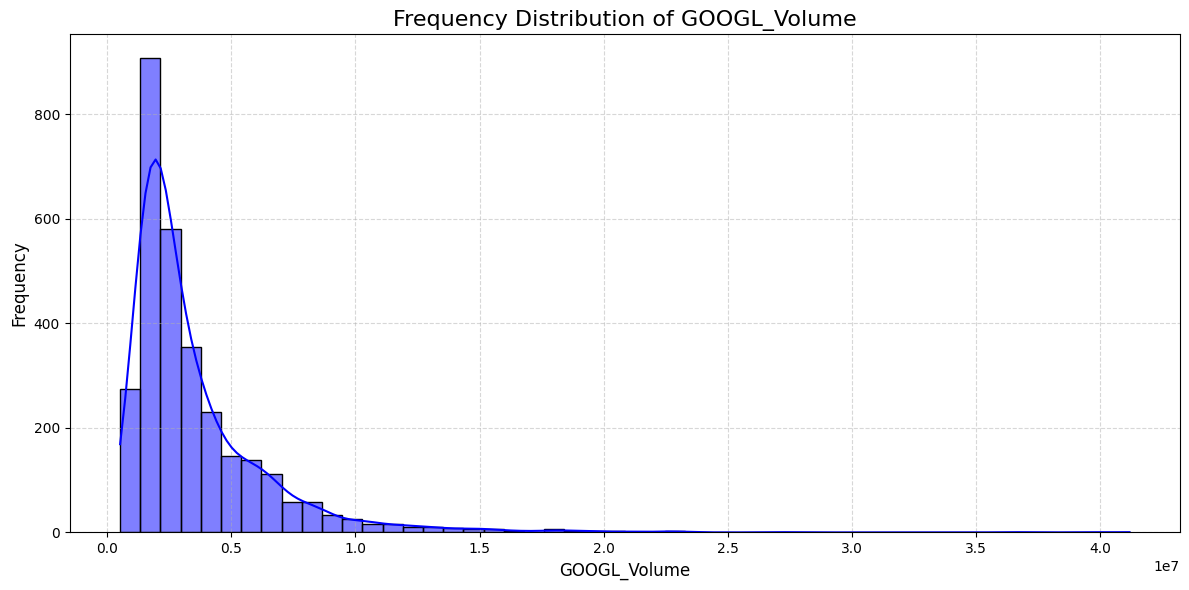

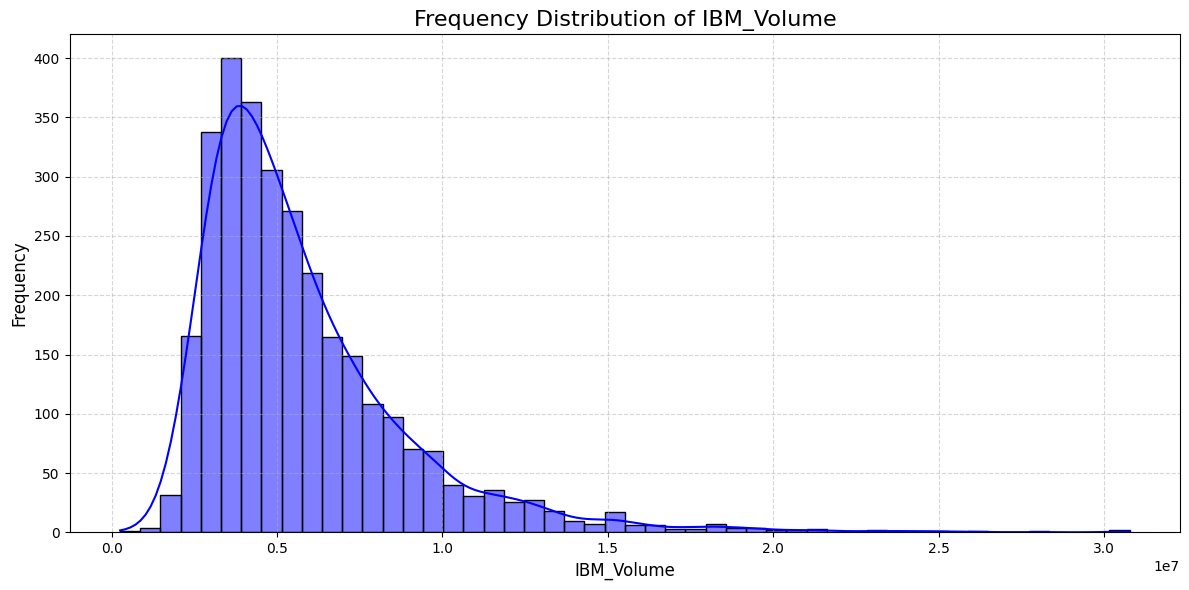

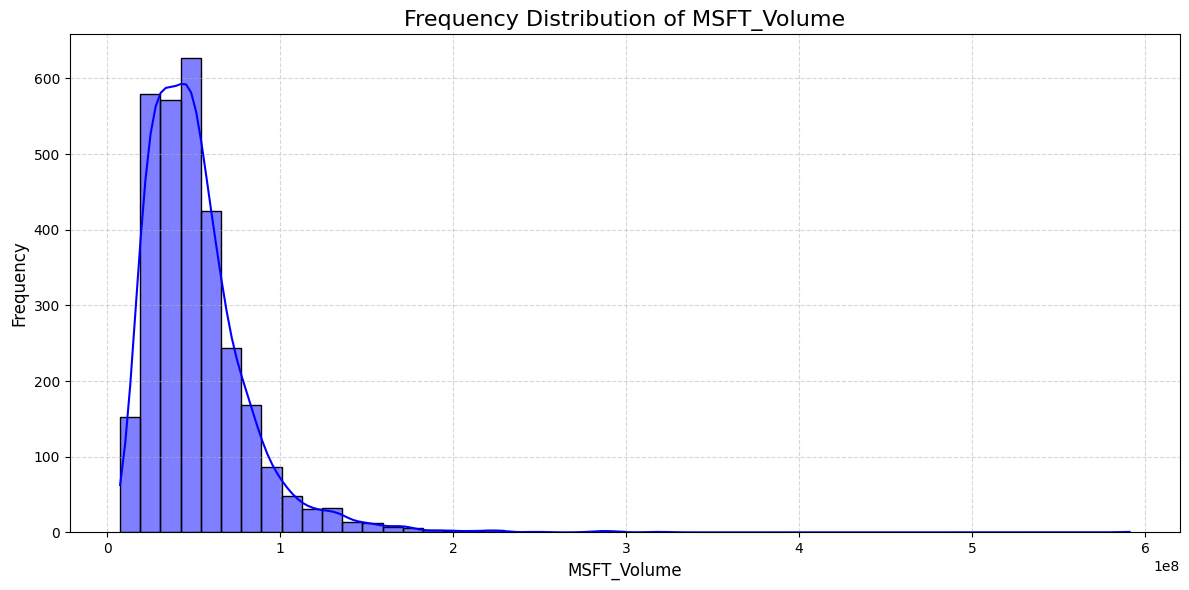

In [13]:
# Frequency distribution of volumes

numeric_cols = combined_stock_df.select_dtypes(include='number').columns
keyword = 'Volume'
volume_cols = [col for col in numeric_cols if keyword.lower() in col.lower()]

for col in volume_cols:
        plt.figure(figsize=(12, 6))
        sns.histplot(combined_stock_df[col].fillna(0), bins=50, kde=True, color='blue')
        plt.title(f'Frequency Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


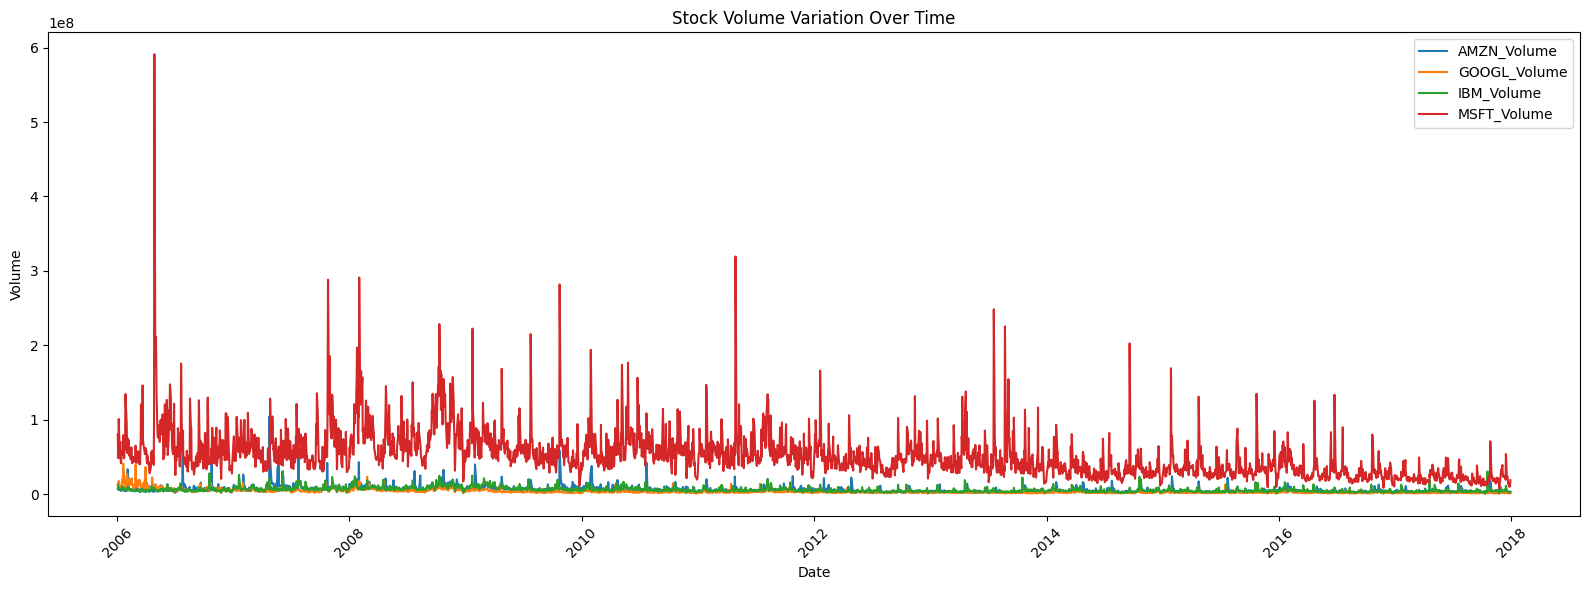

In [14]:
# Stock volume variation over time
keyword = "Volume"
volume_cols = [col for col in combined_stock_df.columns if keyword.lower() in col.lower()]
plt.figure(figsize=(16, 6))
for col in volume_cols:
    plt.plot(combined_stock_df.index, combined_stock_df[col], label=col)

plt.title('Stock Volume Variation Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

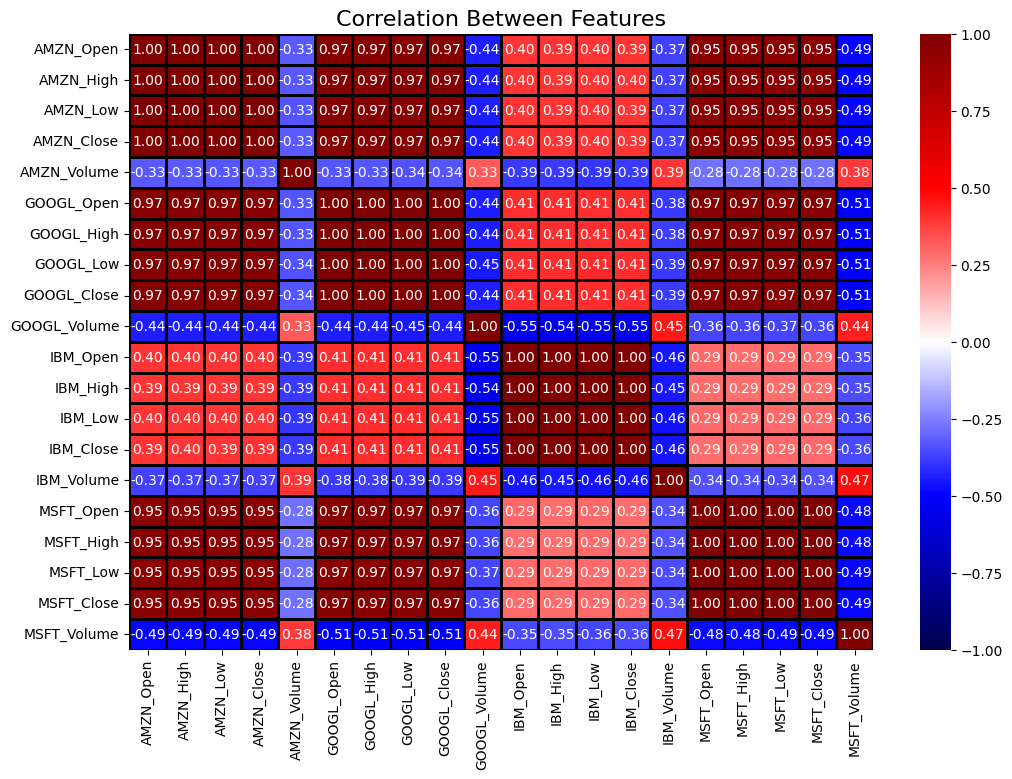

In [15]:
# Analyse correlations

correlation_matrix = combined_stock_df.select_dtypes(include=['number']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='seismic', vmin=-1, vmax=1, linewidths=1, linecolor='black')
plt.title('Correlation Between Features', fontsize=16)
plt.show()


1.   Correlation heatmap indicates that Microsoft , Google and Amazon stocks are highly correlated

2.  IBM stocks behave differently and have less correlation with others

3.  Stock prices of MSFT, GOOGLE and Amazon are closely correlated and high. But IBM stocks are not correlated

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [16]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(df, window_size=20, stride=1, target_stocks=None):

    # If target_stocks not specified, auto-detect columns containing 'Close'
    if target_stocks is None:
        target_stocks = [col for col in df.columns if 'Close' in col]

    X, y = [], []  # Lists to hold input windows and targets

    # Loop over the dataframe with sliding windows
    # Each window has 'window_size' rows, windows move by 'stride' rows each iteration
    for start in range(0, len(df) - window_size, stride):

        # Extract input features window: all columns for rows from 'start' to 'start+window_size-1'
        window = df.iloc[start : start + window_size].values

        # Extract target values: closing prices of target stocks at the row immediately after the window
        target = df.iloc[start + window_size][target_stocks].values

        # Append window and target to the lists
        X.append(window)
        y.append(target)

    # Convert lists to numpy arrays for ML model compatibility
    return np.array(X), np.array(y)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [17]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y, x_scaler=None, y_scaler=None):

    if x_scaler is None:
        x_scaler = StandardScaler()
    if y_scaler is None:
        y_scaler = StandardScaler()

    num_windows, window_size, num_features = X.shape
    X_reshaped = X.reshape(num_windows * window_size, num_features)
    X_scaled_reshaped = x_scaler.fit_transform(X_reshaped)

    # Reshape back to original 3D shape
    scaled_X = X_scaled_reshaped.reshape(num_windows, window_size, num_features)

    # Fit and transform y globally
    scaled_y = y_scaler.fit_transform(y)

    return scaled_X, scaled_y, x_scaler, y_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

In [18]:
def prepare_data_for_rnn(master_data,target_stocks, window_size, window_stride, train_test_split_ratio=0.8):
    # 1. Create windowed data
    X_windowed, y_windowed = create_windowed_data(master_data, window_size, window_stride, target_stocks)

    # 2. Split into training and testing
    split_idx = int(len(X_windowed) * train_test_split_ratio)
    X_train, X_test = X_windowed[:split_idx], X_windowed[split_idx:]
    y_train, y_test = y_windowed[:split_idx], y_windowed[split_idx:]

    # 3. Scale features and targets
    X_train, y_train, x_scaler, y_scaler = scale_windowed_data(X_train, y_train)
    X_test, y_test, _, _ = scale_windowed_data(X_test, y_test, y_scaler=y_scaler)

    return X_train, y_train, X_test, y_test, y_scaler

In [19]:
master_data = combined_stock_df

# Define the target columns — closing prices of stocks you want to predict
target_cols = ['AMZN_Close'] # ['AMZN_Close', 'GOOGL_Close', 'MSFT_Close', 'IBM_Close']

window_size = 20
window_stride = 1
train_test_split_ratio = 0.8

X_train, y_train, X_test, y_test, y_scaler = prepare_data_for_rnn(
    master_data, target_cols, window_size, window_stride, train_test_split_ratio
)

In [20]:
#Printing the train and test data count
print(f"X_train details: {X_train.shape},\n y_train shape: {y_train.shape}\n")
print(f"X_test details: {X_test.shape},\n y_test shape: {y_test.shape}")

X_train details: (2400, 20, 20),
 y_train shape: (2400, 1)

X_test details: (600, 20, 20),
 y_test shape: (600, 1)


#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [21]:
# Define a function to create input and output data points from the master DataFrame

def create_test_train_split(master_data,target_stocks, window_size, window_stride, train_test_split_ratio=0.8):
    # 1. Create windowed data
    X_windowed, y_windowed = create_windowed_data(master_data, window_size, window_stride, target_stocks)

    # 2. Split into training and testing
    split_idx = int(len(X_windowed) * train_test_split_ratio)
    X_train, X_test = X_windowed[:split_idx], X_windowed[split_idx:]
    y_train, y_test = y_windowed[:split_idx], y_windowed[split_idx:]

    # 3. Scale features and targets
    X_train, y_train, x_scaler, y_scaler = scale_windowed_data(X_train, y_train)
    X_test, y_test, _, _ = scale_windowed_data(X_test, y_test, y_scaler=y_scaler)

    return X_train, y_train, X_test, y_test, y_scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

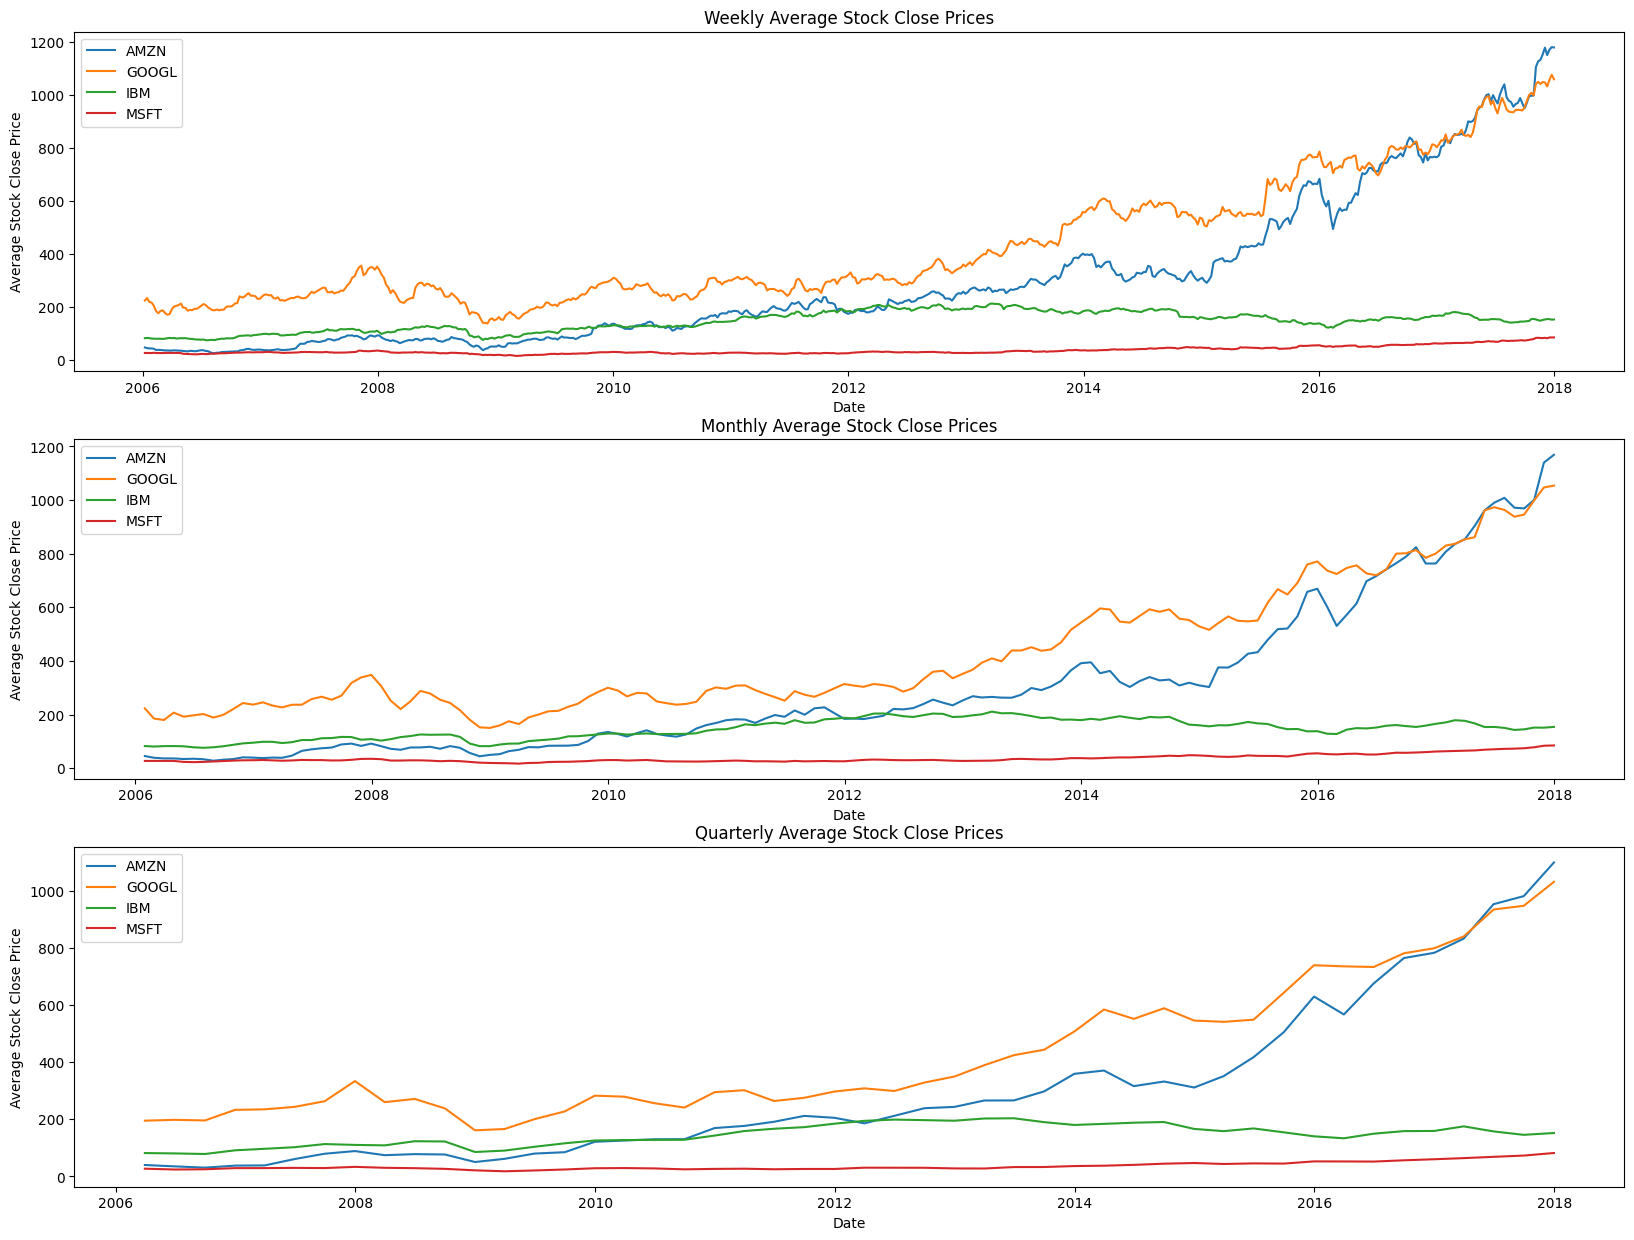

In [22]:
# Checking for patterns in different sequence lengths

combined_stock_df.index = pd.to_datetime(combined_stock_df.index)

# Extract just the Close price columns
close_cols = [col for col in combined_stock_df.columns if col.endswith('_Close')]

freq_map = {'W': 'Weekly', 'M': 'Monthly', 'Q': 'Quarterly'}

plt.figure(figsize=(20, 15))

for i, (freq, label) in enumerate(freq_map.items(), start=1):
    resampled = combined_stock_df[close_cols].resample(freq).mean()

    plt.subplot(3, 1, i)

    # For plotting multiple stocks on same plot
    for col in close_cols:
        sns.lineplot(data=resampled[col], label=col.replace('_Close',''))

    plt.title(f"{label} Average Stock Close Prices")
    plt.xlabel("Date")
    plt.ylabel("Average Stock Close Price")

plt.show()

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [23]:
# Create data instances from the master data frame using decided window size and window stride

window_size = 20
window_stride = 1
target= ['AMZN']
target_cols = [f"{stock}_Close" for stock in target]
split_ratio = 0.8
combined_df = combined_stock_df

# Create train and validation sets using full target column names
X_train, y_train, X_val, y_val, y_scaler = create_test_train_split(
    combined_df,
    target_cols,
    window_size,
    window_stride,
    split_ratio
)

# Print the shapes to confirm
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (2400, 20, 20)
y_train shape: (2400, 1)
X_val shape: (600, 20, 20)
y_val shape: (600, 1)


In [24]:
# Check the number of data points generated
print(f"Number of Training Parameter X ",len(X_train))
print(f"Number of Training Parameter Y",len(y_train))
print(f"Number of Testing Parameter X",len(X_val))
print(f"Number of Testing Parameter Y",len(y_val))

Number of Training Parameter X  2400
Number of Training Parameter Y 2400
Number of Testing Parameter X 600
Number of Testing Parameter Y 600


In [25]:
# Check if the datasets are compatible inputs to neural networks

#Checking the shape of Data

print(f"X_train shape is" ,X_train.shape)
print(f"y_train shape is" ,y_train.shape)
print(f"X_val shape is" ,X_val.shape)
print(f"y_val shape is" ,y_val.shape)


X_train shape is (2400, 20, 20)
y_train shape is (2400, 1)
X_val shape is (600, 20, 20)
y_val shape is (600, 1)


For RNN networks the input data should have the below shape

Input(X) = (number of samples, window size, number of featues)

Output(Y) = (number of samples , target stocks)

Above shows that output is compatible for neural networks

## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [49]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_simple_rnn_model(units, activation, input_shape, dropout_rate, output_dim):

    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=input_shape))
    model.add(Dropout(dropout_rate))  # To prevent overfitting
    model.add(Dense(output_dim))      # Output layer
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Compile model with MSE loss
    return model



1.   Since the task is a regression task on predicitng stock price , mean square error is used as the loss function.
2.   Mean Absolute Error is used as the evaluation metrics



#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [50]:
# Find an optimal configuration of simple RNN
units_list = [16, 32, 64]               # Different RNN unit sizes to try
dropout_rates = [0.1, 0.2]              # Dropout rates to test
activation_list = ['tanh', 'relu']      # Activation functions
input_shape = X_train.shape[1:]         # Shape of input data (time_steps, features)
output_dim = y_train.shape[1]           # Number of target stocks (output nodes)

# To keep track of best model and config
best_val_loss = float('inf')
best_model = None
best_config = None
results = []
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Hyperparameter combinations

for units in units_list:
    for dropout in dropout_rates:
        for activation in activation_list:
            # Build model with current config
            model = create_simple_rnn_model(units, activation, input_shape, dropout, output_dim)

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=10,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )

            # Get the final validation loss
            val_loss = history.history['val_loss'][-1]
            results.append((units, dropout, activation, val_loss))

            print(f"Config: units={units}, dropout={dropout}, activation={activation}, val_loss={val_loss:.4f}")

            # Track best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model
                best_config = (units, dropout, activation)


Config: units=16, dropout=0.1, activation=tanh, val_loss=0.2304
Config: units=16, dropout=0.1, activation=relu, val_loss=0.4949
Config: units=16, dropout=0.2, activation=tanh, val_loss=0.9288
Config: units=16, dropout=0.2, activation=relu, val_loss=0.3020
Config: units=32, dropout=0.1, activation=tanh, val_loss=0.4711
Config: units=32, dropout=0.1, activation=relu, val_loss=0.0927
Config: units=32, dropout=0.2, activation=tanh, val_loss=0.2380
Config: units=32, dropout=0.2, activation=relu, val_loss=0.1463
Config: units=64, dropout=0.1, activation=tanh, val_loss=0.1067
Config: units=64, dropout=0.1, activation=relu, val_loss=0.1141
Config: units=64, dropout=0.2, activation=tanh, val_loss=0.2433
Config: units=64, dropout=0.2, activation=relu, val_loss=0.2024


In [54]:
# Find the best configuration based on evaluation metrics
#Printing this value from the Track best model part in above function
print(f"\n Best Config : Units={best_config[0]}, Dropout={best_config[1]}, Activation={best_config[2]}")


 Best Config : Units=32, Dropout=0.1, Activation=relu


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [55]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

#Use the parameters received in Best config to call the simple rnn model
model_final = create_simple_rnn_model(
    best_config[0], best_config[2], input_shape, best_config[1], output_dim
)

# Fitting using final model

model_final.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.6675 - mae: 0.6171 - val_loss: 0.1466 - val_mae: 0.3021
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1622 - mae: 0.2983 - val_loss: 0.1041 - val_mae: 0.2529
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1097 - mae: 0.2442 - val_loss: 0.0774 - val_mae: 0.2169
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0782 - mae: 0.2058 - val_loss: 0.0534 - val_mae: 0.1741
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0583 - mae: 0.1778 - val_loss: 0.0444 - val_mae: 0.1615
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0519 - mae: 0.1717 - val_loss: 0.0342 - val_mae: 0.1395
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0438 - mae: 0.1576 - val_loss: 0.0321 - val_mae: 0.1368
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0372 - mae: 0.1426 - val_loss: 0.0256 - val_mae: 0.1206
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0359 - m

Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


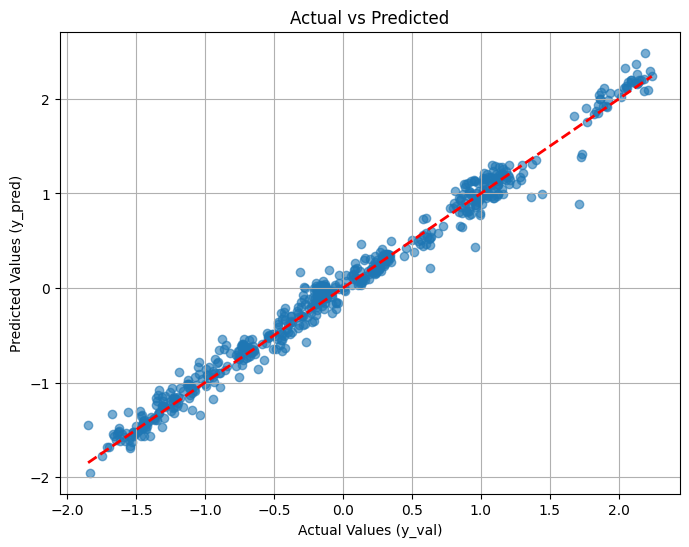

In [56]:
# Predict on the test data and plot

y_pred = model_final.predict(X_val)

#Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--', lw=2)  # perfect prediction line
plt.xlabel('Actual Values (y_val)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()



*   Scatter is more tighter around the line indicating model fits the data well
*   Spread indicates goodness of fit



In [59]:
#Calculating the MAE, MSE ,RMSE and R2 on validation data
for i, stock in enumerate(target):
    mae = mean_absolute_error(y_val[:, i], y_pred[:, i])
    mse = mean_squared_error(y_val[:, i], y_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val[:, i], y_pred[:, i])

    print(f"\n Validation Performance for {stock}:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")


 Validation Performance for AMZN:
MAE  : 0.0904
MSE  : 0.0150
RMSE : 0.1225
R²   : 0.9850


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [58]:
# Compute the performance of the model on the testing data set
#Predicting y_test
y_test_pred = model_final.predict(X_test)

for i, stock in enumerate(target):
    mae = mean_absolute_error(y_test[:, i], y_test_pred[:, i])
    mse = mean_squared_error(y_test[:, i], y_test_pred[:, i])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[:, i], y_test_pred[:, i])

    print(f"Test Performance for {stock}:")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test Performance for AMZN:
MAE  : 0.0904
MSE  : 0.0150
RMSE : 0.1225
R²   : 0.9850


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [32]:
# # Define a function to create a model and specify default values for hyperparameters



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [33]:
# Find an optimal configuration



#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [34]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model



In [35]:
# Compute the performance of the model on the testing data set


Plotting the actual vs predicted values

In [36]:
# Predict on the test data


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [37]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [38]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [39]:
# Find an optimal configuration of simple RNN



In [40]:
# Find the best configuration



In [41]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [42]:
# Compute the performance of the model on the testing data set



In [43]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [44]:
# Find an optimal configuration of advanced RNN



In [45]:
# Find the best configuration



In [46]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [47]:
# Compute the performance of the model on the testing data set



In [48]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.